# EPMT - Data Migration Study

## Background

Data migration operations constitute operations that either move or copy data
from one location to another. Often, hierarchical storage management (HSM) requires
prefectching data from auxillary storage to a local (more expensive) storage prior
to operations on the data. We also include archiving, unarchiving and deletion in
data migration operations. 

In this study we analyze a large collection of post-processing jobs and determine
the fraction of time spent on data migration operations in relation to the total
runtime of the jobs.

## Data used for the study
The jobs span `439` jobids falling between `4839165` to `4899603`. These were provided
by GFDL in a database dump on 05/06/2020.

In [1]:
# this is the main API module
import epmt_query as eq

# we need maptplotlib and seaborn for plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
# make sure we are using a recent version
eq.version()

(3, 8, 18)

We have a curated list of data-movement operations provided by GFDL.

In [3]:
DM_OPS = ['op:hsmput', 'op:dmget', 'op:untar', 'op:mv', 'op:dmput', 'op:hsmget', 'op:rm', 'op:cp']

We will use the powerful API call `ops_costs`, which determines the time spent in operations, and also
computes it as a fraction of total job times. We will use all the jobs in the database. At present,
the database only contains the `493` jobs from the GFDL database dump.

`ops_costs` takes the jobs, the tags defining the operations to measure, and the metric of choice. It allows measuring `duration` and `cpu_time`. We will use `duration` as the metric as we want to measure wall-clock time. 

For `duration` we take care not to double-count overlapping processes. So, the computation is decidedly slower than for a `metric` like `cpu_time`, where we can use database operations to aggregate counts across processes in a job.
In our study, the call took around 30 minutes to process the 500 jobs in the database when using `duration` as
the `metric`, while the same call took just 5 minutes with `cpu_time` as the metric.

### Data-movement `duration` analysis
In the following section we use the `duration` metric to determine the fractional time spent
in data movement.

In [4]:
(ops_percent, ops_df, total_job_time, ops_df_agg_by_job) = eq.ops_costs(jobs = [], tags = DM_OPS, metric = 'duration')

In [5]:
ops_percent, total_job_time

(67.102, 1693709129331.0)

So, across all the jobs, approximately two-thirds of the wallclock time was spent in data movement.
That's quite surprising!

The dataframe below shows the aggregated metrics for each operation. Since, there were `493` jobs, and
8 operations per job (at most), the number of rows is excessive, and we will prune the output to see
the top rows by `duration`. As you can see the `hsmget` operation dominates.

In [6]:
# only showing the top-10 rows (sorted by duration) to keep the output concise
ops_df.sort_values('duration', ascending=False)[:10]

,jobid,tags,duration,cminflt,majflt,time_waiting,PERF_COUNT_SW_CPU_CLOCK,usertime,cutime,time_oncpu,...,invol_ctxsw,systemtime,cmajflt,syscr,vol_ctxsw,processor,rdtsc_duration,numtids,rssmax,cancelled_write_bytes
1629,4877796,{'op': 'hsmget'},5.991662e+09,300949037,55,385047105143,1330625953633,1505831404,7301010000,1904348597232,...,150659,351444044,154,6642171,3625807,0,78996631823784,86949,561993688,2203648
1086,4877801,{'op': 'hsmget'},5.894431e+09,75167826,31,67536612515,87985011164,137904099,418880000,220694924659,...,53144,72685237,59,1661079,735004,0,28960560089550,19818,154623380,983040
399,4877800,{'op': 'hsmget'},5.869572e+09,257956276,83,297514203592,274156434992,456883688,1348660000,768160706149,...,201317,272195790,151,6132218,3203866,0,40575248136814,78723,474603612,1572864
1593,4877794,{'op': 'hsmget'},5.761952e+09,122795264,62,156860914293,313458373255,404586808,1715600000,549785876373,...,68610,127346902,193,2701606,1463860,0,35559280559755,35069,232054124,974848
861,4877795,{'op': 'hsmget'},5.761742e+09,64761324,1,84506743129,118619659500,174215699,676430000,240201637677,...,36872,57361253,5,1414656,737719,0,-12643067036203422,17557,130707524,741376
91,4877811,{'op': 'hsmget'},5.738425e+09,11644990,70,15416084411,26936048933,37587931,154730000,50728845585,...,6576,11416970,165,261153,172126,0,19880244954283,3437,21799832,81920
1587,4877821,{'op': 'hsmget'},5.733998e+09,53724408,1,64547018766,242451731549,273989583,1341010000,341497413792,...,27244,59533865,5,1171275,653218,0,29717374036315,15060,103658996,491520
192,4877819,{'op': 'hsmget'},5.731696e+09,11495744,9,15224254832,109758714304,108757141,584940000,132449627425,...,6064,21883353,17,256854,172163,0,22718035723906,3384,21553352,81920
302,4877820,{'op': 'hsmget'},5.728264e+09,95307143,8,121154712775,59821583553,162969743,438020000,241783530617,...,45586,63996478,9,2096893,1137104,0,25164046773911,27433,179413004,737280
1467,4877798,{'op': 'hsmget'},5.727027e+09,52442219,12,95283648075,133409380317,179550812,672460000,270472421911,...,34859,83374346,24,1173567,631693,0,27629709628810,15094,102461044,487424


The above dataframe shows the metrics for each operation. The `ops_costs` API call also returns another
dataframe that groups the operations in a job, so one can see at glance the total data-movement time
for each (and as a percentage of total job duration). Since we have too many jobs, we will restrict
the listing to the top few.

In [7]:
# top-20 rows shown
ops_df_agg_by_job.sort_values('dm_duration', ascending=False)[:20]

,jobid,dm_duration,job_duration,dm_duration%
240,4868943,8.703285e+09,1.849700e+10,47.0
274,4877796,8.343098e+09,1.468037e+10,57.0
206,4884950,8.118046e+09,2.326301e+10,35.0
232,4839167,7.900293e+09,2.040303e+10,39.0
178,4887609,7.370950e+09,1.772124e+10,42.0
173,4893807,7.306170e+09,1.677814e+10,44.0
268,4877794,7.230925e+09,1.065763e+10,68.0
74,4864953,7.225494e+09,1.834067e+10,39.0
267,4877821,6.821228e+09,1.031938e+10,66.0
357,4865042,6.741912e+09,1.713411e+10,39.0


In [8]:
ops_df_agg_by_job['dm_duration%'].describe()

count    439.000000
mean      66.423690
std       23.828497
min       13.000000
25%       48.000000
50%       72.000000
75%       88.000000
max       99.000000
Name: dm_duration%, dtype: float64

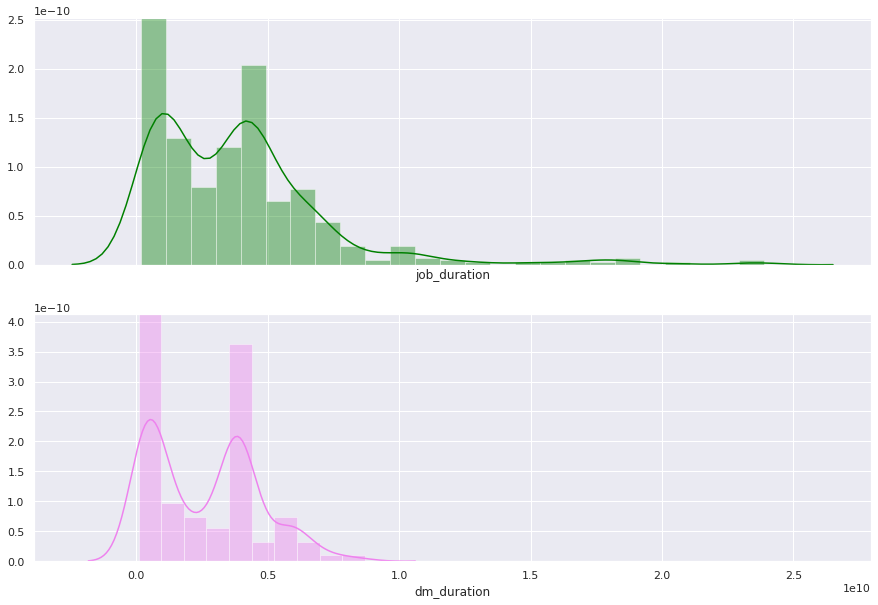

In [37]:
fig, ax =plt.subplots(2, 1, figsize=(15,10),sharex=True)
sns.distplot(ops_df_agg_by_job['job_duration'], color='green', ax=ax[0])
sns.distplot(ops_df_agg_by_job['dm_duration'], color='violet',ax=ax[1])

The plots above show the job and data-movement duration normalized histograms along with KDE. Notice the similar bimodal distribution of both plots, possibly stemming from HSM, wherein data movement in some jobs requires fetching from slower auxillary or distant network storage, while others benefit from finding the data in local cache.

The plot below shows a normalized histogram of the `dm_duration%` along with the KDE curve. 

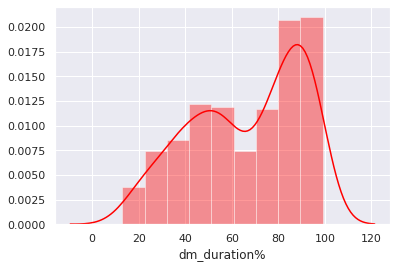

In [21]:
sns.distplot(ops_df_agg_by_job['dm_duration%'], color='red')

And, below is a cumulative kernel density plot with a `rug plot` showing the individual data points.

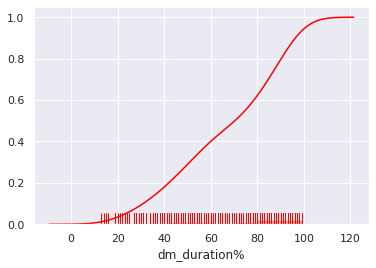

In [10]:
sns.distplot(ops_df_agg_by_job['dm_duration%'], color='red', rug=True, kde_kws = {'cumulative': True})

What is most striking is that for almost `40%` of the jobs, the data migration operations took more than `80%` of the job time! 

### Data-movement `cpu_time` analysis

In the previous section we did an analysis using the `duration` metric. Now, we will do the
same for the `cpu_time` metric. There are certain inherent advantages to using `cpu_time` as
the metric for measurement. There is no possibility of double-counting for background
processes. This allows us to do metric aggregation in the database layer. 
This makes the `op_costs` call significantly faster when using `cpu_time` instead
of `duration`. 

`cpu_time` is an aggregation of `usertime` and `systemtime`. In effect it is the time spent
when the process is running on the CPU or when the CPU is doing work on behalf of the process.
Since data movement is primarily a form of I/O, we expect the fractional CPU cycles spent
in data movement to be less than the fractional `duration` in the same activity.

Let's see if that's so.

In [11]:
(cpu_ops_percent, cpu_ops_df, cpu_total_job_time, cpu_ops_df_agg_by_job) = eq.ops_costs(jobs = [], tags = DM_OPS, metric = 'cpu_time')
ops_percent, total_job_time

(67.102, 1693709129331.0)

In [12]:
# only showing the top-10 rows (sorted by duration) to keep the output concise
cpu_ops_df.sort_values('cpu_time', ascending=False)[:10]

,jobid,tags,cpu_time,cminflt,majflt,time_waiting,PERF_COUNT_SW_CPU_CLOCK,usertime,cutime,time_oncpu,...,invol_ctxsw,systemtime,cmajflt,syscr,vol_ctxsw,processor,rdtsc_duration,numtids,rssmax,cancelled_write_bytes
1375,4839167,{'op': 'hsmget'},3.248472e+09,384722990,294,430290433807,2627609424079,2598815274,13600150000,3303578482514,...,517350,649656739,1209,9106197,4356745,0,134883842228428,113699,731352500,2834432
444,4864953,{'op': 'hsmget'},3.187208e+09,384059513,438,416799682414,2555738423112,2554174393,13236770000,3244616298606,...,501778,633034100,1584,9089560,4357437,0,124853031057008,113461,730280084,2875392
1224,4884950,{'op': 'hsmget'},3.054612e+09,290740489,172,737815050827,2106020621212,2308846691,10823250000,3099405684179,...,221170,745764894,612,6602958,3597981,0,105491703100656,86149,550293068,2203648
1424,4868943,{'op': 'hsmget'},3.031278e+09,291041179,51,699791130171,2098590726255,2298879268,10806250000,3074860098784,...,219597,732398425,176,6609649,3592071,0,105366887055229,86254,550899516,2207744
1170,4872930,{'op': 'hsmget'},2.809351e+09,290422332,200,644109113853,1946161327571,2157448984,10196360000,2853616993856,...,183020,651902115,927,6608229,3604209,0,93788109918778,86028,549757704,2076672
1059,4887609,{'op': 'hsmget'},2.774064e+09,290414464,59,610992164355,1966944134061,2090308136,9974990000,2817967498240,...,211552,683756032,169,6594811,3572444,0,94054838518984,86028,549718360,2211840
1425,4868943,{'op': 'mv'},2.704087e+09,9580267,87,6567370085,2616599921542,2428480196,4596610000,2707514141344,...,25846,275606636,32,800907,1365229,0,90279122511364,5655,135752760,911265792
1667,4877824,{'op': 'hsmget'},2.693481e+09,290049392,153,603424716763,1871132997739,2081026808,9831430000,2737025886132,...,183133,612454494,641,6594834,3596370,0,91032972447147,86028,549434368,2093056
1060,4887609,{'op': 'mv'},2.414642e+09,9584931,55,8682633297,2328088896806,2152309214,4048990000,2417791304836,...,23784,262332610,5,800941,1347043,0,83785664637180,5655,135727568,911294464
1029,4893807,{'op': 'hsmget'},2.320747e+09,291572680,75,373346320024,1750288984551,1781657188,8744580000,2364284475926,...,394491,539089368,261,6882967,3581694,0,103386849634295,86300,550695540,2203648


In [13]:
# top-20 rows shown
cpu_ops_df_agg_by_job.sort_values('dm_cpu_time', ascending=False)[:20]

,jobid,dm_cpu_time,job_cpu_time,dm_cpu_time%
240,4868943,5.874729e+09,1.527531e+10,38.0
206,4884950,5.487188e+09,1.541197e+10,36.0
178,4887609,5.329664e+09,1.544569e+10,35.0
74,4864953,4.798484e+09,1.421563e+10,34.0
232,4839167,4.774193e+09,1.488696e+10,32.0
197,4872930,4.498551e+09,1.496321e+10,30.0
281,4877824,4.213319e+09,1.439432e+10,29.0
173,4893807,3.908317e+09,1.294307e+10,30.0
220,4868995,3.893805e+09,1.314886e+10,30.0
357,4865042,3.614228e+09,1.307186e+10,28.0


In [14]:
cpu_ops_df_agg_by_job['dm_cpu_time%'].describe()

count    439.000000
mean      38.441913
std       20.000472
min       10.000000
25%       24.000000
50%       32.000000
75%       52.000000
max       88.000000
Name: dm_cpu_time%, dtype: float64

Even here we see a marked dispersion and a high standard deviation, and as expected, a smaller
average (`38%`) of the CPU cycles v. the average duration being `66%`.

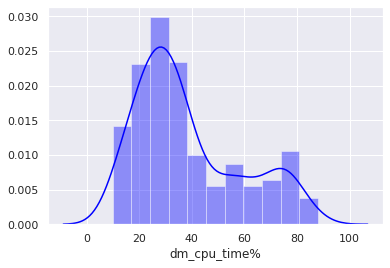

In [17]:
sns.distplot(cpu_ops_df_agg_by_job['dm_cpu_time%'], color='blue')

This plot is also bimodal, although the second peak has a significantly lower frequency.
Below, we see the cumulative KDE plot for the `cpu_time` metric. Notice, that the
embedded rug plot shows a higher concentration around `30%`, while the `duration`
cumulative KDE plot showed a higher concentation around `80%`.

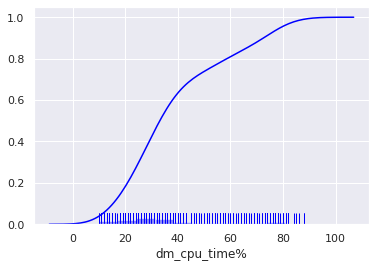

In [18]:
sns.distplot(cpu_ops_df_agg_by_job['dm_cpu_time%'], color='blue', rug=True, kde_kws = {'cumulative': True})

Below we show the plots together.

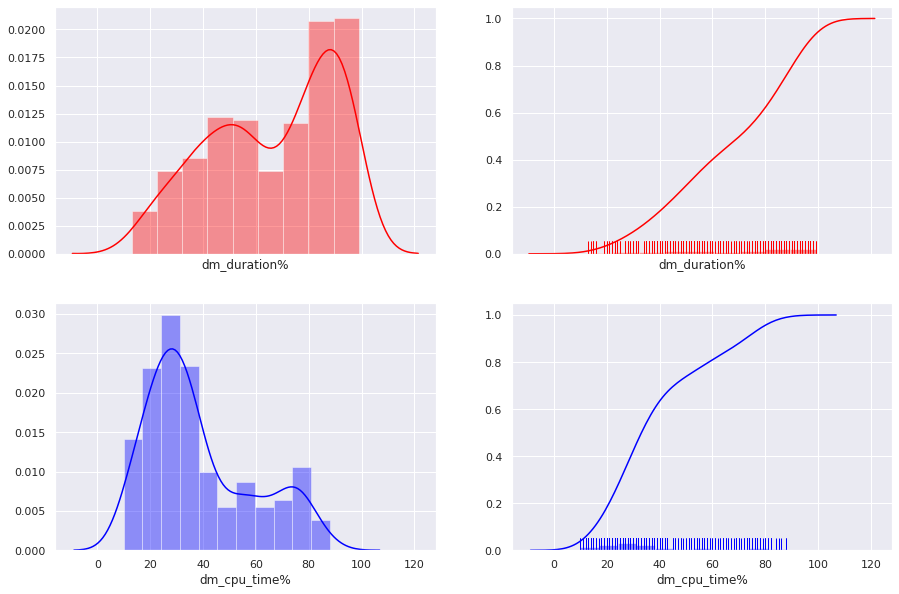

In [43]:
fig_all, ax_all =plt.subplots(2, 2, figsize=(15,10),sharex=True)
sns.distplot(ops_df_agg_by_job['dm_duration%'], color='red', ax=ax_all[0][0])
sns.distplot(ops_df_agg_by_job['dm_duration%'], color='red', rug=True, kde_kws = {'cumulative': True}, ax=ax_all[0][1])
sns.distplot(cpu_ops_df_agg_by_job['dm_cpu_time%'], color='blue', ax=ax_all[1][0])
sns.distplot(cpu_ops_df_agg_by_job['dm_cpu_time%'], color='blue', rug=True, kde_kws = {'cumulative': True},ax=ax_all[1][1])